# Developing machine learning Regression model with Spark MLlib

In this lab you will learn how to develop a machine learning regression model using Spark MLlib in Azure Databricks environment. During the course of the lab you will walk through cardinal phases of a machine learning workflow from data gathering and cleaning through feature engineering and modeling to model inferencing.

## Lab scenario
You will develop a machine learning  model to forecast number of crimes per each district of city of Chicago per each crime type per day. The dataset used during the lab contains historical information about crime situation of city of Chicago plus historical weather data and social economic data. You will use Azure Databricks unified analytics platform and Spark MLlib library and other option such as SKLearn. You will make use of Azure ML Services to assist in model management, version and metrics tracking during development

In [2]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.
#you need to install AzureML library with this syntax in the cluster azureml-sdk[databricks] --ignore-installed PyYAML
#Due to conflict of Scikit-learn version in Spark-Learn (come with default sklearn 0.19) and Sckit-learn 0.20.2 required in this notebook. 
#Please follow following sequence: first install spark-learn then install Sckit-learn==0.20.2 If you restart your cluster, remove both sckit learn and spark learn. Do not 
#let the default installation run which will follow a reverse sequence
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
subscription_id = dbutils.secrets.get("commonakv", "subscriptionid") #you should be owner or contributor
resource_group = "hcnDthCommon" #you should be owner or contributor

workspace_name = "amlcommonws" #your workspace name

workspace_region = "westus2" #your region
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      auth = InteractiveLoginAuthentication(force=True, tenant_id=dbutils.secrets.get("commonakv", "tenantid")),
                      resource_group = resource_group, 
                      location = workspace_region,
                      
                      exist_ok=True)



Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code BAM7FTMYX to authenticate.
Interactive authentication successfully completed.

In [3]:
#Create or retrieve your experiment. Experiment is a unit to group together experiment runs that share same nature and you're interested to compare runs together. 

from azureml.core.run import Run
from azureml.core.experiment import Experiment
import shutil
myexperiment = Experiment(ws, "AML_Crime_Prediction")

## Loading and Feature Engineering

## Approach 1: Using Spark MLlib 

### What is MLlib?

MLlib is a package, built on and included in Spark, that provides interfaces for
- gathering and cleaning data,
- feature engineering and feature selection,
- training and tuning large scale supervised and unsupervised machine learning models, 
- and using those models in production.

### MLlib Concepts

![MLlib](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/MLlib.png)

#### Split data into training and test sets

At this point we will split our dataset into separate training and test sets.

In [8]:
# loading data from the stored table
crime_df = spark.sql("select * from crime_dataset").na.drop()
# Split the dataset randomly into 85% for training and 15% for testing.
train, test = crime_df.randomSplit([0.85, 0.15], 0)
train.cache()
test.cache()
print("We have {} training examples and {} test examples.".format(train.count(), test.count()))

We have 2016041 training examples and 355932 test examples.

#### Visualize our data

Now that we have preprocessed our features and prepared a training dataset, we can use visualizations to get more insights about the data.

Calling `display()` on a DataFrame in Databricks and clicking the plot icon below the table will let you draw and pivot various plots.  See the [Visualizations section of the Databricks Guide](https://docs.databricks.com/user-guide/visualizations/index.html) for more ideas.

In [10]:
display(train)

crime_count,year,week,day,district,primary_type,school_test_performance,population,Unemployment_Rte,Median_Household_Income,Average_Commute_Time,Area,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
1,2001,1,Friday,1.0,BATTERY,Excellent,24886.0,6.039999999999892,64706.0,27.599999999997785,1.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,11.0,OTHER OFFENSE,Below Average,38105.0,5.3299999999993695,28695.0,36.19999999998712,4.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,11.0,OTHER OFFENSE,Poor,64267.0,5.2100000000019255,41711.0,35.80000000001299,4.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,12.0,OTHER OFFENSE,Below Average,52548.0,5.649999999996617,54344.0,30.69999999998215,3.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,19.0,OTHER OFFENSE,Above Average,66617.0,5.679999999996072,93702.0,29.90000000001451,3.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,19.0,OTHER OFFENSE,Below Average,87291.0,5.309999999998083,46572.0,30.699999999974906,4.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,22.0,OTHER OFFENSE,Below Average,49952.0,7.51000000000238,62868.0,35.59999999998892,7.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,24.0,OTHER OFFENSE,Average,45274.0,4.620000000000918,52055.0,32.29999999999288,2.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,25.0,BATTERY,Average,74298.0,5.089999999997645,62214.0,36.199999999992095,7.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001,1,Friday,4.0,OTHER OFFENSE,Below Average,84155.0,8.109999999989883,43572.0,36.10000000004082,16.0,0.0,0.0,12.0,34.0,16.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0


You can also use other visualization libraries.

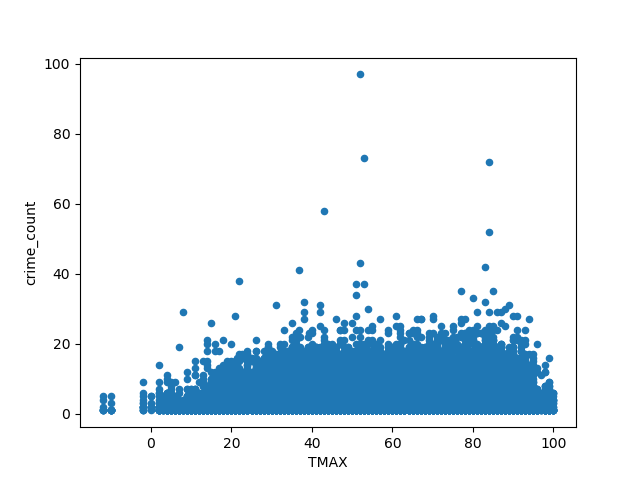

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Get a sample of data
sample = train.sample(False, 0.05, 42).toPandas()

ax = sample.plot.scatter(x='TMAX', y='crime_count')
display()

#### Save training and testing data

At this point, we are going to save the datasets using `Parquet` format

d ### Train a Machine Learning Pipeline

Now that we have understood our data and prepared it as a DataFrame with pre-processed data, we are ready to train an ML classifier. In this lab we will focus on a single algorithm - Gradient-boosted tree classifier - however in most cases you should go through a more thorough model selection process to find an algorithm that best fits you scenario and training data. We will also demonstrate how to automate hyperparameter tuning using Spark ML validators.

To achieve it, we will put together a simple Spark ML Pipeline.

Most Spark ML algorithms, including GBT, expect the training data to be provided as a *numeric* column to represent the label and a column of type *Vector* to represent the features. 

The features in our datasets are a mix of *numeric* and *string* values. *String* columns represent categorical features. Most *numeric* columns are continous features. Before we can configure hyper parameter tuning and Random Forest stages of our pipeline we will need to add a few data transformation steps.

Our complete pipeline has the following stages:

* `StringIndexer`: Convert string columns to categorical features
* `VectorAssembler`: Assemble the feature columns into a feature vector.
* `VectorIndexer`: Identify columns which should be treated as categorical. This is done heuristically, identifying any column with a small number of distinct values as being categorical.  For us, this will include columns like `occupation` or `homeowner` .
* `Classifier`: This stage will train the classification algorithm.
* `CrossValidator`: The machine learning algorithms have several [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization), and tuning them to our data can improve performance of the model.  We will do this tuning using Spark's [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_&#40;statistics&#41;) framework, which automatically tests a grid of hyperparameters and chooses the best.

![Image of Pipeline](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/pipeline.png)

First, we define the feature processing stages of the Pipeline:
* Convert string columns to categorical features. 
* Assemble feature columns into a feature vector. 
* Identify categorical features, and index them.
![Image of feature processing](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/features.png)

In [16]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.sql.types import *
from pyspark.ml import Pipeline
def build_pipeline(features_to_remove):
# Create a list of string indexers - one for each string column
  stringCols = [field.name for field in train.schema if field.dataType == StringType()]
  stringIndexers = [StringIndexer().setInputCol(name).setOutputCol(name+"_idx") for name in stringCols]

  # Get a list of all numeric columns
  numericCols = [field.name for field in train.schema if field.dataType != StringType()]

  # Remove a label column and other unwanted features
  for feature in features_to_remove:
    numericCols.remove(feature)


  #We create two pipelines, one with different sets of columns to compare results
  #Pipeline 1, all original columns are included


  # Create a list of all feature columns
  featureCols = numericCols + [name + "_idx" for name in stringCols]

  # This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
  vectorAssembler = VectorAssembler(inputCols=featureCols, outputCol="rawFeatures")

  # This identifies categorical features and indexes them.
  vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=30)

  # Create a pipeline
  stages = stringIndexers + [vectorAssembler, vectorIndexer]
  pipeline = Pipeline(stages=stages)
  return pipeline

# Check the Pipeline operation
# display(pipeline.fit(train).transform(train))


Second, we define the model training stage of the Pipeline. `GBTClassifier` takes feature vectors and labels as input and learns to predict labels of new examples.
![RF image](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/train.png)

Third, we wrap the model training stage within a `CrossValidator` stage.  `CrossValidator` knows how to call the classifier algorithm with different hyperparameter settings.  It will train multiple models and choose the best one, based on minimizing some metric.  In this lab, our metric is *AUC*.

![Crossvalidate](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/tune.png)

Finally, we can tie our feature processing and model training stages together into a single `Pipeline`.

![Image of Pipeline](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/pipeline.png)

#### Train the Pipeline!

Now that we have set up our workflow, we can train the Pipeline in a single call.  Calling `fit()` will run feature processing, model tuning, and training in a single call.  We get back a fitted Pipeline with the best model found.

***Note***: This next cell can take up to **10 minutes**.  This is because it is training *a lot* of trees:
* For each random sample of data in Cross Validation,
  * For each setting of the hyperparameters,
    * `CrossValidator` is training a separate GBT ensemble which contains many Decision Trees.
    
Since our training set is unbalanced we will apply a technique called *under sampling*. We will use all instances of a minority class but select a random sample from the majority class.

In [22]:
#Training with GLR model

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import GeneralizedLinearRegression
import os
model_name = "crime_prediction_GLR.mml"
model_dbfs = os.path.join("/dbfs", model_name)
run_history_name = 'spark-ml-notebook'

myexperiment = Experiment(ws, "AML_Crime_Prediction")
root_run = myexperiment.start_logging()

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="crime_count", predictionCol="prediction", metricName="rmse")

regressor = GeneralizedLinearRegression(family="gaussian", link="identity",featuresCol="features", labelCol="crime_count")

paramGrid = ParamGridBuilder()\
  .addGrid(regressor.regParam, [0.2, 0.3])\
  .addGrid(regressor.maxIter, [15, 30])\
  .build()
cv = CrossValidator(estimator=regressor, evaluator=evaluator,estimatorParamMaps=paramGrid, numFolds=3)

with root_run.child_run("full columns") as run:
  run.log("featureset", "full")
  # dt = DecisionTreeRegressor(featuresCol="features")



  pipeline = build_pipeline(['crime_count', 'year'])

  stages = pipeline.getStages()
  stages = stages + [cv]
  pipeline.setStages(stages)
  print(pipeline.getStages())
  pipelineModel = pipeline.fit(train)
  predictions = pipelineModel.transform(test).cache()
  print("Model  weather features: {} on  test set: {}".format(evaluator.getMetricName(), evaluator.evaluate(predictions, {})))
  run.log(evaluator.getMetricName(), evaluator.evaluate(predictions, {}))
  #Save model to local dbfs
  pipelineModel.write().overwrite().save(model_name)

  # upload the serialized model into run history record
  mdl, ext = model_name.split(".")
  model_zip = mdl + ".zip"
  shutil.make_archive(mdl, 'zip', model_dbfs)
  run.upload_file("outputs/" + model_name, model_zip)        

  # now delete the serialized model from local folder since it is already uploaded to run history 
  shutil.rmtree(model_dbfs)
  os.remove(model_zip)
with root_run.child_run("removed weather columns") as run:
  run.log("featureset", "minus weather")
  regressor = GeneralizedLinearRegression(family="gaussian", link="identity",featuresCol="features", labelCol="crime_count")
  # dt = DecisionTreeRegressor(featuresCol="features")


  cv = CrossValidator(estimator=regressor, evaluator=evaluator,estimatorParamMaps=paramGrid, numFolds=3)
  pipeline = build_pipeline(['crime_count', 'year','PRCP','SNOW','SNWD','TMAX','TMIN','TOBS','WT01','WT03','WT04','WT05','WT06','WT11'])
  stages = pipeline.getStages()
  stages = stages + [cv]
  pipeline.setStages(stages)
  pipelineModel = pipeline.fit(train)
  predictions = pipelineModel.transform(test).cache()
  print("Model without weather features: {} on  test set: {}".format(evaluator.getMetricName(), evaluator.evaluate(predictions, {})))
  run.log(evaluator.getMetricName(), evaluator.evaluate(predictions, {}))

  pipelineModel.write().overwrite().save(model_name)

  # upload the serialized model into run history record
  mdl, ext = model_name.split(".")
  model_zip = mdl + ".zip"
  shutil.make_archive(mdl, 'zip', model_dbfs)
  run.upload_file("outputs/" + model_name, model_zip)        

  # now delete the serialized model from local folder since it is already uploaded to run history 
  shutil.rmtree(model_dbfs)
  os.remove(model_zip)
    
root_run_id = root_run.id
print ("run id:", root_run.id)

#Load all run metrics from run history into a dictionary object.
child_runs = {}

for r in root_run.get_children():
    child_runs[r.id] = r
    
metrics = root_run.get_metrics(recursive=True)
best_run_id = min(metrics, key = lambda k: metrics[k][evaluator.getMetricName()])
best_run = child_runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics {0}: {1} by model {2}'.format(evaluator.getMetricName(), metrics[best_run_id][evaluator.getMetricName()],metrics[best_run_id]["featureset"]))
root_run.log("algorithm", "GLR")

root_run.log("rmse", metrics[best_run_id][evaluator.getMetricName()])
# Declare run completed

root_run.complete()

#Download the model from the best run to a local folder
best_model_file_name = "crime_prediction{0}.zip".format(metrics[best_run_id]["featureset"])
best_run.download_file(name = 'outputs/' + model_name, output_file_path = best_model_file_name)
##unzip the model to dbfs (as load() seems to require that) and load it.
if os.path.isfile(model_dbfs) or os.path.isdir(model_dbfs):
    shutil.rmtree(model_dbfs)
shutil.unpack_archive(best_model_file_name, model_dbfs)

#Register the model. THis is assuming that the model is downloaded from Azure ML service not from DBFS
from azureml.core.model import Model
mymodel = Model.register(model_path = model_dbfs, # this points to a local file
                       model_name = model_name, # this is the name the model is registered as, am using same name for both path and name.                 
                       description = "Crime Prediction using GLR {0}".format(metrics[best_run_id]["featureset"]),
                       workspace = ws)

print(mymodel.name, mymodel.description,  mymodel.version)


[StringIndexer_918f15d9c963, StringIndexer_32538d83cddf, StringIndexer_8a45986dab23, StringIndexer_0d1987b6ad9a, VectorAssembler_5fb599715986, VectorIndexer_c179e0543be0, CrossValidator_207707cef0ed]
/databricks/spark/python/pyspark/ml/util.py:785: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Model weather features: rmse on test set: 2.828990715372402
Model without weather features: rmse on test set: 2.8319905639828544
run id: 088389e7-ef75-47c8-b0e4-92a702d27773
Best run is: c5a5406e-e6ab-4daf-a600-ea1706e245f5
Metrics rmse: 2.828990715372402 by model full
Registering model crime_prediction_GLR.mml
crime_prediction_GLR.mml Crime Prediction using GLR full 1

### A short section for R users

####Approach using Sparklyr

In [25]:
%r
# Installing latest version of Rcpp
install.packages("Rcpp")

# Installing sparklyr takes a few minutes, becauses it installs +10 dependencies.
install.packages("sparklyr")

# Load sparklyr package.
library(sparklyr)

In [26]:
%sql describe extended crime_dataset

In [27]:
%r
library(SparkR)
# spark.conf
library(sparklyr)
library(dplyr)

sc <- spark_connect(method = "databricks")
crime_tbl <-  sdf_sql(sc, "select * from crime_dataset")
sdf_repartition(crime_tbl, partition_by = cbind('district'))


In [28]:
%r
partitions <- df %>%
  sdf_partition(training = 0.7, test = 0.3, seed = 1111)

df_training <- partitions$training
df_test <- partitions$test
df <- crime_tbl %>%
  filter(!is.na(district)) %>%
  mutate(
    district = paste0("d", district)) %>%
  select(crime_count , primary_type, school_test_performance, day,SNOW, population,Unemployment_Rte ) 


crimes_pipeline <- ml_pipeline(sc) %>%
  ft_dplyr_transformer(
    tbl = df_training
    ) %>%
  ft_string_indexer(
    input_col = "day",
    output_col = "day_idx"  ) %>%
  ft_string_indexer(
    input_col = "primary_type",
    output_col = "primary_type_idx"  ) %>%
  ft_string_indexer(
    input_col = "school_test_performance",
    output_col = "school_test_performance_idx"  ) %>%
#   ft_bucketizer(
#     input.col = "sched_dep_time",
#     output.col = "hours",
#     splits = c(400, 800, 1200, 1600, 2000, 2400)
#   )  %>%

  ft_vector_assembler(
    input_cols = cbind("day_idx","primary_type_idx","SNOW", "population","Unemployment_Rte")
    ,output_col = "features",
  )  %>%

#   ft_r_formula(crime_count ~ features) %>% 
  ml_random_forest_classifier(features_col = "features",
  label_col = "school_test_performance_idx",max_depth = 10)


In [29]:
%r
crimes_pipeline <- ml_pipeline(sc) %>%
  ft_dplyr_transformer(
    tbl = df_training
    ) %>%
  ft_bucketizer(
    input_col = "crime_count",
    output_col = "crime_level",
    splits = c(400, 800, 1200, 1600, 2000, 2400)
  ) %>%
  ft_vector_assembler(
    input_cols = cbind("primary_type","SNOW", "population","Unemployment_Rte")
    ,output_col = "features",
  )  %>%
  ml_random_forest_classifier(formula = crime_level ~ school_test_performance+day +primary_type+SNOW+population+Unemployment_Rte,max_depth = 10)

# model <- ml_random_forest_classifier(
#   df,
#   formula = school_test_performance ~ day +primary_type+SNOW+population+Unemployment_Rte
# )
# ml_tree_feature_importance(model)



In [30]:
%r

fitted_pipeline <- ml_fit(
  crimes_pipeline,
  df_training
)

# 


In [31]:
%r 
# install.packages("tidyverse")
# ml_tree_feature_importance(
#   ml_stage(fitted_pipeline, 6)
# )
# ml_stage(model, 'decision_tree_classifier')$feature_importances

# tibble(
#   token = unlist(ml_stage(model, 'count_vectorizer')$vocabulary),
#   importance = ml_stage(model, 'decision_tree_classifier')$feature_importances
# )
# ml_stage(fitted_pipeline,"random_forest_classifier")$feature_importances
# ml_stage(fitted_pipeline,6)

library('tidyverse')
feature_cols <- 
  c("day","primary_type","SNOW", "population","Unemployment_Rte")

my_importance <- as.data.frame(cbind(feature_cols, ml_stage(fitted_pipeline, 6)$feature_importances))
colnames(my_importance) <- c('feature','importance')
my_importance  <- my_importance  %>% arrange(-as.numeric(importance))


In [32]:
%r
next_ds <- crime_tbl %>% filter(primary_type == 'THEFT')
next_ds

####Approach using SparkR

In [34]:
#Preparing data for a R model
processing_pipeline = build_pipeline(['crime_count', 'year'])
processing_model = processing_pipeline.fit(crime_df)
rdata = processing_model.transform(crime_df)
rdata.registerTempTable("rdata")

In [35]:
%r
library(SparkR)
rdf <- sql("select crime_count as label, features from rdata")
df_list <- randomSplit(rdf, c(8.5,1.5), 2)


modelPath <- "dbfs:/mnt/ml/rmodel"
training <- df_list[[1]]
test <- df_list[[2]]
# # Fit a random forest regression model with spark.randomForest
randomForestModel <- spark.randomForest(training, label ~ features, "regression", numTrees = 10)

# Model summary
summary(randomForestModel)
write.ml(randomForestModel, modelPath)

# Prediction
predictions <- predict(model, test)
head(predictions)


In [36]:
#Training with Random forest model

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import RandomForestRegressor
import os
model_name = "crime_prediction_RDF.mml"
model_dbfs = os.path.join("/dbfs", model_name)
run_history_name = 'spark-ml-notebook'

myexperiment = Experiment(ws, "AML_Crime_Prediction")
root_run = myexperiment.start_logging()

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="crime_count", predictionCol="prediction", metricName="rmse")

regressor = RandomForestRegressor(featuresCol="features", labelCol="crime_count") 

paramGrid = ParamGridBuilder()\
  .addGrid(regressor.maxDepth, [10])\
  .addGrid(regressor.numTrees, [150])\
  .addGrid(regressor.maxBins , [55])\
  .build()

cv = CrossValidator(estimator=regressor, evaluator=evaluator,estimatorParamMaps=paramGrid, numFolds=2)

with root_run.child_run("full columns") as run:
  run.log("featureset", "full")



  pipeline = build_pipeline(['crime_count', 'year'])

  stages = pipeline.getStages()
  stages = stages + [cv]
  pipeline.setStages(stages)
  print(pipeline.getStages())
  pipelineModel = pipeline.fit(train)
  predictions = pipelineModel.transform(test).cache()
  print("Model  weather features: {} on  test set: {}".format(evaluator.getMetricName(), evaluator.evaluate(predictions, {})))
  run.log(evaluator.getMetricName(), evaluator.evaluate(predictions, {}))

  pipelineModel.write().overwrite().save(model_name)

  # upload the serialized model into run history record
  mdl, ext = model_name.split(".")
  model_zip = mdl + ".zip"
  shutil.make_archive(mdl, 'zip', model_dbfs)
  run.upload_file("outputs/" + model_name, model_zip)        

  # now delete the serialized model from local folder since it is already uploaded to run history 
  shutil.rmtree(model_dbfs)
  os.remove(model_zip)

    
root_run_id = root_run.id
print ("run id:", root_run.id)

#Load all run metrics from run history into a dictionary object.
child_runs = {}

for r in root_run.get_children():
    child_runs[r.id] = r
    
metrics = root_run.get_metrics(recursive=True)
best_run_id = min(metrics, key = lambda k: metrics[k][evaluator.getMetricName()])
best_run = child_runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics {0}: {1} by model {2}'.format(evaluator.getMetricName(), metrics[best_run_id][evaluator.getMetricName()],metrics[best_run_id]["featureset"]))
root_run.log("algorithm", "Randomforest")

root_run.log("rmse", metrics[best_run_id][evaluator.getMetricName()])
# Declare run completed

root_run.complete()


#Download the model from the best run to a local folder
best_model_file_name = "crim_prediction{0}.zip".format(metrics[best_run_id]["featureset"])
best_run.download_file(name = 'outputs/' + model_name, output_file_path = best_model_file_name)
##unzip the model to dbfs (as load() seems to require that) and load it.
if os.path.isfile(model_dbfs) or os.path.isdir(model_dbfs):
    shutil.rmtree(model_dbfs)
shutil.unpack_archive(best_model_file_name, model_dbfs)

#Register the model. THis is assuming that the model is downloaded from Azure ML service not from DBFS
from azureml.core.model import Model
mymodel = Model.register(model_path = model_dbfs, # this points to a local file
                       model_name = model_name, # this is the name the model is registered as, am using same name for both path and name.                 
                       description = "Crime Prediction using Randomforest {0}".format(metrics[best_run_id]["featureset"]),
                       workspace = ws)

print(mymodel.name, mymodel.description,  mymodel.version)

[StringIndexer_e250738d655e, StringIndexer_b4b3f2d8896b, StringIndexer_664d1b280431, StringIndexer_5088685d871e, VectorAssembler_604ec831341c, VectorIndexer_a82d153f7aab, CrossValidator_c2b6632e82fc]
/databricks/spark/python/pyspark/ml/util.py:785: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Model weather features: rmse on test set: 1.7279717267889165
run id: 22df0f4c-9382-4a9c-b5eb-8dbc4dd80dc4
Best run is: 9a6c61f6-2861-4ae2-8be1-5bd5c2b3121a
Metrics rmse: 1.7279717267889165 by model full
Registering model crime_prediction_RDF.mml
crime_prediction_RDF.mml Crime Prediction using Randomforest full 1

## Approach 2: Training using traditional SK Learn

In many cases Spark MLib though scalable does not meet your needs. In General, SK Learn offers you much more option to fine tune models and has more algorithms to support your needs. Also, you may want train model using a deep learning library that Spark ML is not idea for the task. Below is model training using SKLearn and Azure ML can always be used to track metrics and manage your models

In [39]:
# loading data from the stored table, limit 100k out of 8 m records as training in single node with SK learn will be slow
crime_df = spark.sql("select * from crime_dataset").na.drop().sample(withReplacement=False, fraction=0.1,seed =112 )
display(crime_df)

crime_count,year,week,day,district,primary_type,school_test_performance,population,Unemployment_Rte,Median_Household_Income,Average_Commute_Time,Area,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
4,2004,12,Thursday,25.0,THEFT,Below Average,75570.0,5.167499999998066,52551.0,34.82499999998058,4.0,0.019999999999999643,0.0,0.0,36.0,27.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,22,Thursday,25.0,OTHER OFFENSE,Poor,64267.0,5.2100000000019255,41711.0,35.80000000001299,4.0,0.0,0.0,0.0,79.0,46.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,42,Thursday,25.0,BATTERY,Below Average,79477.0,5.214999999998072,50558.0,33.44999999997869,4.0,0.0,0.0,0.0,61.0,45.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2003,37,Sunday,7.0,OTHER OFFENSE,Below Average,40916.0,6.079999999999536,33080.0,42.89999999995529,4.0,0.6699999999999853,0.0,0.0,84.0,67.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,4,Thursday,7.0,OTHER OFFENSE,Poor,35921.0,6.6199999999964385,23875.0,40.69999999998456,4.0,0.0,0.0,1.0,37.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,12,Wednesday,7.0,ASSAULT,Below Average,40916.0,6.079999999999536,33080.0,42.89999999995529,4.0,0.039999999999999286,0.0,1.0,31.0,29.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,37,Thursday,7.0,OTHER OFFENSE,Below Average,40916.0,6.079999999999536,33080.0,42.89999999995529,4.0,0.0,0.0,0.0,70.0,56.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011,44,Tuesday,25.0,OTHER OFFENSE,Poor,90407.0,5.19000000000189,50923.0,35.39999999998447,5.0,0.0,0.0,0.0,54.0,35.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2006,20,Tuesday,25.0,THEFT,Average,49195.6,5.033999999999741,60718.8,32.92000000000124,4.6,0.00999999999999982,0.0,0.0,59.0,46.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012,15,Monday,25.0,BATTERY,Below Average,71663.0,5.11999999999806,54544.0,36.199999999982474,4.0,0.0,0.0,0.0,65.0,46.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
crime_df.count()

Out[ 3 ]: 236820

In [41]:
import sklearn
print(sklearn.__version__)

0.20.2

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.externals import joblib
from spark_sklearn import GridSearchCV

from sklearn import metrics as metr
import numpy as np
import os
# from  sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
#directory to save preprocessing and prediction models
savedir ='/dbfs/ml'
model_name = 'ml.joblib'
model_dbfs = os.path.join("/dbfs", model_name)

ft_name = 'ft.joblib'
# dbutils.fs.rm(savedir, True)
# dbutils.fs.mkdirs(savedir)

ft_destination = os.path.join(savedir, ft_name)
ml_destination = os.path.join(savedir, model_name)
pdCrime = crime_df.toPandas()
features_df = pdCrime.drop(['crime_count','year'], axis=1)
y = pdCrime.pop('crime_count')
ft= ColumnTransformer(transformers = [("ohe",OneHotEncoder(handle_unknown='ignore'),['day','primary_type','school_test_performance', 'district'])],remainder =StandardScaler())
#transform 
ft.fit(features_df)
if not os.path.isdir(savedir):
  os.mkdir(savedir)
#save the feature transformation model
joblib.dump(value =ft,filename=ft_destination)
X = ft.transform(features_df)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("We have {} training examples and {} test examples.".format(X_train.size, Y_train.size))
root_run = myexperiment.start_logging()

#build randomforest regressor
with root_run.child_run("randomforest") as run:
  run.log("algorithm", "SKLearn_Randomforest")
  randomforestregressor = RandomForestRegressor(max_depth=2, random_state=0,  n_estimators=10)

  param_grid = {
      "max_depth": [6],
        "n_estimators": [100]

  }

  regression_model = GridSearchCV(sc, randomforestregressor, param_grid, cv=3)




  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
  regression_model.fit(X_train, y_train)
  y_pred = regression_model.predict(X_test)

  mae = metr.mean_absolute_error(y_test, y_pred)
  mse = metr.mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)


  print('mae %f\t mse %f\t rmse %f'% (mae, mse, rmse))
  run.log("rmse", rmse)

  joblib.dump(regression_model.best_estimator_,ml_destination)

  mdl, ext = model_name.split(".")
  model_zip = mdl + ".zip"
  shutil.make_archive(mdl, 'zip', savedir)
  run.upload_file("outputs/" + model_zip, model_zip)        

  # now delete the serialized model from local folder since it is already uploaded to run history 
  os.remove(model_zip)
  
with root_run.child_run("ElasticNet") as run:
  run.log("algorithm", "SKLearn_ElasticNet")
  elasregressor = ElasticNet()

  param_grid = {
      "alpha": [ 1.0,2.0],

  }
# clf_spark_xgb = GridSearchCV(sc, clf_xgb, random_grid, n_jobs=20)

  regression_model = GridSearchCV(sc, elasregressor, param_grid, cv=3)




  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
  regression_model.fit(X_train, y_train)
  y_pred = regression_model.predict(X_test)

  mae = metr.mean_absolute_error(y_test, y_pred)
  mse = metr.mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)


  print('mae %f\t mse %f\t rmse %f'% (mae, mse, rmse))
  run.log("rmse", rmse)


  joblib.dump(regression_model.best_estimator_,ml_destination)

  mdl, ext = model_name.split(".")
  model_zip = mdl + ".zip"
  shutil.make_archive(mdl, 'zip', savedir)
  run.upload_file("outputs/" + model_zip, model_zip)        

  # now delete the serialized model from local folder since it is already uploaded to run history 
  os.remove(model_zip)
  
root_run_id = root_run.id
print ("run id:", root_run.id)

#Load all run metrics from run history into a dictionary object.
child_runs = {}

for r in root_run.get_children():
    child_runs[r.id] = r

metrics = root_run.get_metrics(recursive=True)
best_run_id = min(metrics, key = lambda k: metrics[k]["rmse"])
best_run = child_runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics {0}: {1} by model {2}'.format("rmse", metrics[best_run_id]["rmse"],metrics[best_run_id]["algorithm"]))
root_run.log("algorithm", metrics[best_run_id]["algorithm"])

root_run.log("rmse", metrics[best_run_id]["rmse"])
# Declare run completed
root_run.complete()


#Download the model from the best run to a local folder
best_model_file_name = "crime_prediction{0}.zip".format(metrics[best_run_id]["algorithm"])
best_run.download_file(name = 'outputs/' + model_zip, output_file_path = best_model_file_name)
##unzip the model to dbfs (as load() seems to require that) and load it.
if os.path.isfile(model_dbfs) or os.path.isdir(model_dbfs):
    shutil.rmtree(model_dbfs)
shutil.unpack_archive(best_model_file_name, model_dbfs)


#Register the model. THis is assuming that the model is downloaded from Azure ML service not from DBFS
from azureml.core.model import Model
mymodel = Model.register(model_path = model_dbfs, # this points to a local file
                       model_name = model_name, # this is the name the model is registered as, am using same name for both path and name.                 
                       description = "Crime Prediction using  {0}".format(metrics[best_run_id]["algorithm"]),
                       workspace = ws)

print(mymodel.name, mymodel.description,  mymodel.version)

/databricks/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
 return self.partial_fit(X, y)
/databricks/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
 return self.fit(X, **fit_params).transform(X)
/databricks/python/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
 res = transformer.transform(X)
We have 120970620 training examples and 2016177 test examples.
mae 1.367818 mse 4.927338 rmse 2.219761
mae 1.957335 mse 8.581211 rmse 2.929370
run id: 2414694b-c897-4cec-9454-60c99638c9dc
Best run is: a534c690-12a9-4374-a13a-6c5538981adf
Metrics rmse: 2.2197608505860833 by model SKLearn_Randomforest
Registering model ml.joblib
ml.joblib Crime Prediction using SKLearn_Randomforest 1

##Creating any custom report from Azure ML Runs

In [44]:
rmse_list =[]
runs =myexperiment.get_runs(include_children=True)
for run in runs:
  metrics = run.get_metrics()

  rmse = metrics.get("rmse", 999.0)
  if rmse != 999.0:
    metrics = run.get_metrics()
    run_id = run.id
    experiement =run.experiment.name
    algorithm = metrics.get("algorithm", "None")
    row = {"algorithm":algorithm, "rmse": rmse, "run_id":run_id, "experiment":experiement}
    rmse_list.append(row)
print(rmse_list)
display(spark.createDataFrame(rmse_list))

##Parallelize SKLearn grid search using Spark-Learn

In [46]:
from spark_sklearn import GridSearchCV
from xgboost import XGBClassifier
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 1200, num = 4)]
# Number of features to consider at every split
learning_rate = [0.1, 0.2]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
# Minimum number of samples required to split a node
min_child_weight = [5, 11]
# Minimum number of samples required at each leaf node
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
# class_weight =['balanced']
# class_weight.append(None)

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'base_score':[0.4,0.5,0.6]
#                'nthread':[4,8]
              }
sc =spark.sparkContext
clf_xgb = XGBClassifier(n_jobs=4)

# clf_spark_xgb = GridSearchCV(sc, clf_xgb, random_grid, n_jobs=20)
# clf_spark_xgb.fit(train_x, train_y)
# best_model = clf_spark_xgb.best_estimator_
# y_pred = best_model.predict(test_x)
# accuracy=accuracy_score(test_y, y_pred)
# print("accuracy sore is:",accuracy)
# print(best_model)